Train shape: (1752, 13)
Test shape : (750, 13)

Target distribution:
Class
B    884
A    868
Name: count, dtype: int64


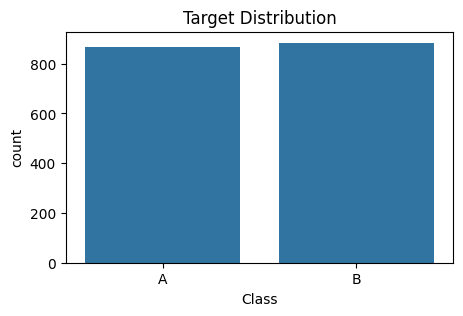

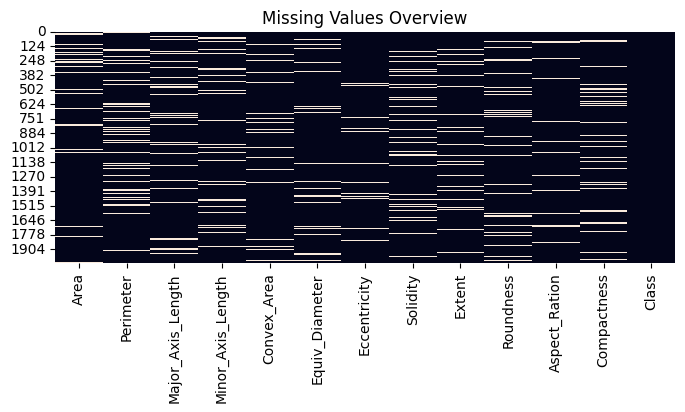

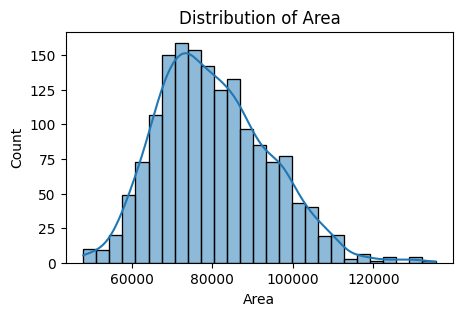

KeyError: "['id'] not found in axis"

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


# -------------------- CONFIG --------------------
TRAIN_PATH = "/content/train.csv"
TEST_PATH  = "/content/test.csv"
TARGET = "Class"
ID_COL = "id"

# -------------------- LOAD DATA --------------------
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

train = train.dropna(subset=[TARGET])

print("Train shape:", train.shape)
print("Test shape :", test.shape)


# -------------------- LIGHT EDA --------------------
print("\nTarget distribution:")
print(train[TARGET].value_counts())

plt.figure(figsize=(5,3))
sns.countplot(x=train[TARGET])
plt.title("Target Distribution")
plt.show()

plt.figure(figsize=(8,3))
sns.heatmap(train.isnull(), cbar=False)
plt.title("Missing Values Overview")
plt.show()

# numeric feature distribution (first numeric column only)
num_cols_eda = train.select_dtypes(include="number").columns.drop(ID_COL, errors="ignore")
if len(num_cols_eda) > 0:
    plt.figure(figsize=(5,3))
    sns.histplot(train[num_cols_eda[0]], kde=True)
    plt.title(f"Distribution of {num_cols_eda[0]}")
    plt.show()

# categorical vs target (first categorical column only)
cat_cols_eda = train.select_dtypes(exclude="number").columns.drop(TARGET, errors="ignore")
if len(cat_cols_eda) > 0:
    plt.figure(figsize=(6,3))
    sns.countplot(data=train, x=cat_cols_eda[0], hue=TARGET)
    plt.xticks(rotation=30)
    plt.title(f"{cat_cols_eda[0]} vs {TARGET}")
    plt.show()


# -------------------- FEATURES / TARGET --------------------
X = train.drop([TARGET,ID_COL], axis=1)
y = train[TARGET]
X_test = test.drop(ID_COL, axis=1)
test_ids = test[ID_COL]


# -------------------- TARGET ENCODING --------------------
le = LabelEncoder()
y = le.fit_transform(y)


# -------------------- FEATURE TYPES --------------------
num_cols = X.select_dtypes(include="number").columns
cat_cols = X.select_dtypes(exclude="number").columns


# -------------------- PREPROCESSING --------------------
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), num_cols),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])


# -------------------- MODELS --------------------
models = {
    "LogReg": LogisticRegression(max_iter=1000, multi_class="auto"),
    "GradientBoost": GradientBoostingClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced"
    )
}


# -------------------- TRAIN / VALIDATE --------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scores = {}

for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocess),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    acc = accuracy_score(y_val, preds)

    scores[name] = acc
    print(f"{name} accuracy: {acc:.4f}")


# -------------------- SELECT BEST MODEL --------------------
best_name = max(scores, key=scores.get)
best_model = models[best_name]

print(f"\nBest model: {best_name}")


# -------------------- TRAIN ON FULL DATA --------------------
final_pipe = Pipeline([
    ("prep", preprocess),
    ("model", best_model)
])

final_pipe.fit(X, y)


# -------------------- TEST PREDICTIONS --------------------
test_preds = final_pipe.predict(X_test)
test_preds = le.inverse_transform(test_preds)


# -------------------- SUBMISSION --------------------
s# ============================================================
# 1️⃣ LABEL SUBMISSION
# ============================================================

# label_preds = final_pipe.predict(X_test)
# label_preds = le.inverse_transform(label_preds)

# submission_labels = pd.DataFrame({
#     ID_COL: test_ids,
#     TARGET: label_preds
# })

# submission_labels.to_csv("submission_labels.csv", index=False)
# print("Saved submission_labels.csv")


# ============================================================
# 2️⃣ PROBABILITY SUBMISSION
# ============================================================

probs = final_pipe.predict_proba(X_test)

classes = list(le.classes_)      # ['C', 'CL', 'D']
required = ["C", "CL", "D"]      # match sample submission

prob_dict = {}
for cls in required:
    idx = classes.index(cls)
    prob_dict[f"Status_{cls}"] = probs[:, idx]

submission_probs = pd.DataFrame({
    ID_COL: test_ids,
    **prob_dict
})

submission_probs.to_csv("submission_probabilities.csv", index=False)
print("Saved submission_probabilities.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')